In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import keras

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras import Model, layers

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-07-01 18:52:08.152786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Global settings

In [2]:
mode = '86' # 'mean' averages the 86 components, '86' keeps them, 'pca' reduces them to pca_dim
model = 'lstm' # 'conv' | 'lstm'

sequence_length = 20
epochs = 5 # or 10
pca_dim = 20

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data loading

In [4]:
data_normal = np.load('KukaNormal.npy')
data_slow = np.load('KukaSlow.npy')[:, 0:-1]       #Discards the label column
dimensions = np.load('KukaColumnNames.npy')[0:-1]  #Discards the label
data = np.concatenate((data_normal, data_slow))

target_normal = np.zeros(data_normal.shape[0])
target_slow = np.ones(data_slow.shape[0])

df_normal = pd.DataFrame(data_normal, columns=dimensions)
df_slow = pd.DataFrame(data_slow, columns=dimensions)
df_normal.tail()

,action,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_frequency,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,sensor_id1_AccX,...,sensor_id7_AccY,sensor_id7_AccZ,sensor_id7_GyroX,sensor_id7_GyroY,sensor_id7_GyroZ,sensor_id7_q1,sensor_id7_q2,sensor_id7_q3,sensor_id7_q4,sensor_id7_temp
233787,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.754395,...,-0.002441,1.000488,0.000000,0.000000,0.0,-0.172724,-0.048044,0.251768,0.951037,180.24
233788,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.750977,...,-0.002930,1.000977,0.000000,0.000000,0.0,-0.172724,-0.048044,0.251768,0.951037,180.24
233789,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.754395,...,-0.003418,0.999512,0.000000,0.000000,0.0,-0.172724,-0.048044,0.251768,0.951037,180.24
233790,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.762695,...,-0.004883,1.000000,0.000000,0.061035,0.0,-0.172932,-0.048179,0.251648,0.951024,180.24
233791,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.747559,...,-0.003906,1.002441,-0.061035,0.000000,0.0,-0.172956,-0.048274,0.251584,0.951032,180.24


# Plots
Plots of different sensor readings

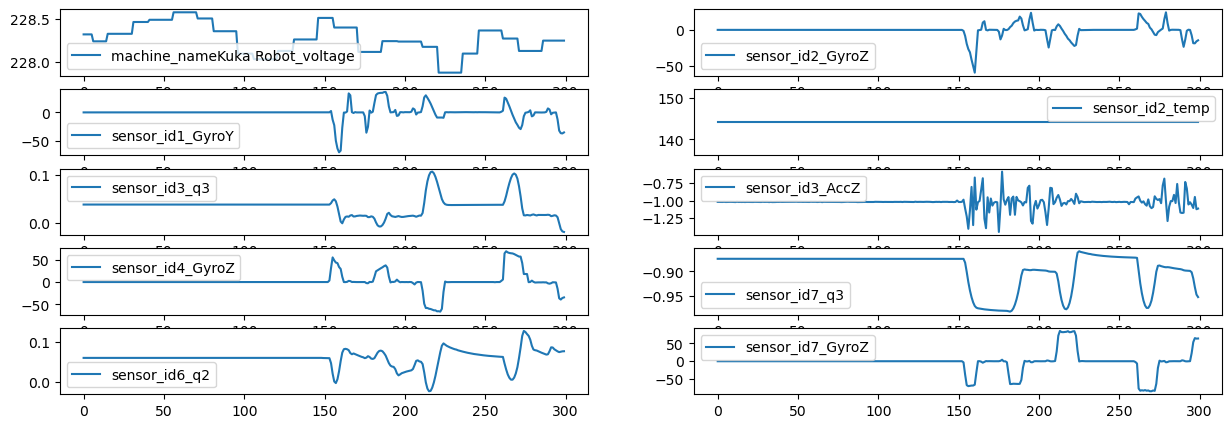

In [5]:
rows, columns = 5, 2
samples = 300

fig, ax = plt.subplots(rows, columns, figsize=(15, 5))
for r in range(rows):
    for c in range(columns):
        sensor = np.random.randint(len(dimensions))
        ax[r][c].plot(data_normal[0:samples, sensor], label=dimensions[sensor])
        ax[r][c].legend()

# Preprocessing
The 86 sensor values are averaged if in 'mean' mode, PCA reduced if in 'pca' mode, and the values are minmax-scaled.

In [6]:
if mode == 'mean':
    data_normal = np.mean(data_normal, axis=1)
    data_slow = np.mean(data_slow, axis=1)

In [7]:
df_normal = pd.DataFrame(data_normal)
df_slow = pd.DataFrame(data_slow)
df_normal.tail()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
233787,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.754395,...,-0.002441,1.000488,0.000000,0.000000,0.0,-0.172724,-0.048044,0.251768,0.951037,180.24
233788,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.750977,...,-0.002930,1.000977,0.000000,0.000000,0.0,-0.172724,-0.048044,0.251768,0.951037,180.24
233789,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.754395,...,-0.003418,0.999512,0.000000,0.000000,0.0,-0.172724,-0.048044,0.251768,0.951037,180.24
233790,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.762695,...,-0.004883,1.000000,0.000000,0.061035,0.0,-0.172932,-0.048179,0.251648,0.951024,180.24
233791,0.0,160.462463,0.993556,50.0,321.580872,125.725021,0.783517,-99.697563,231.03653,-0.747559,...,-0.003906,1.002441,-0.061035,0.000000,0.0,-0.172956,-0.048274,0.251584,0.951032,180.24


In [8]:
if mode == 'mean':
    data_normal = data_normal.reshape(-1, 1) # (N,) ---> (N, 1)
    data_slow = data_slow.reshape(-1, 1)

ss = MinMaxScaler().fit(data_normal)
data_normal = ss.transform(data_normal)
data_slow = ss.transform(data_slow)

In [9]:
if mode == 'pca':
    pca = PCA(n_components=pca_dim)
    pca.fit(data_normal)
    data_normal = pca.transform(data_normal)
    data_slow = pca.transform(data_slow)

In [10]:
if mode == 'mean':
    n_points = 1000
    dimension = 11

    fig, ax = plt.subplots(1, 1, figsize=(17, 5))
    if mode == 'mean':
        ax.plot(data_normal[0:n_points], color='green', label='Normal signal');
        ax.plot(data_slow[0:n_points], color='red', label='Anomalous signal');
    else:
        ax.plot(data_normal[0:n_points, dimension], color='green', label='Normal signal');
        ax.plot(data_slow[0:n_points, dimension], color='red', label='Anomalous signal');
    ax.legend();

# Data windowing
The shape of the dataset passes from (N, 1) to (N, s, 1), where *s* is the sequence length.

In [11]:
data_normal = np.array([data_normal[i:i+sequence_length,:] for i in range(0, len(data_normal)-sequence_length)])
data_slow = np.array([data_slow[i:i+sequence_length,:] for i in range(0, len(data_slow)-sequence_length)])
print(data_normal.shape)
print(data_slow.shape)

(233772, 20, 86)
(41518, 20, 86)


### Sequence display
Only considering sensor 10

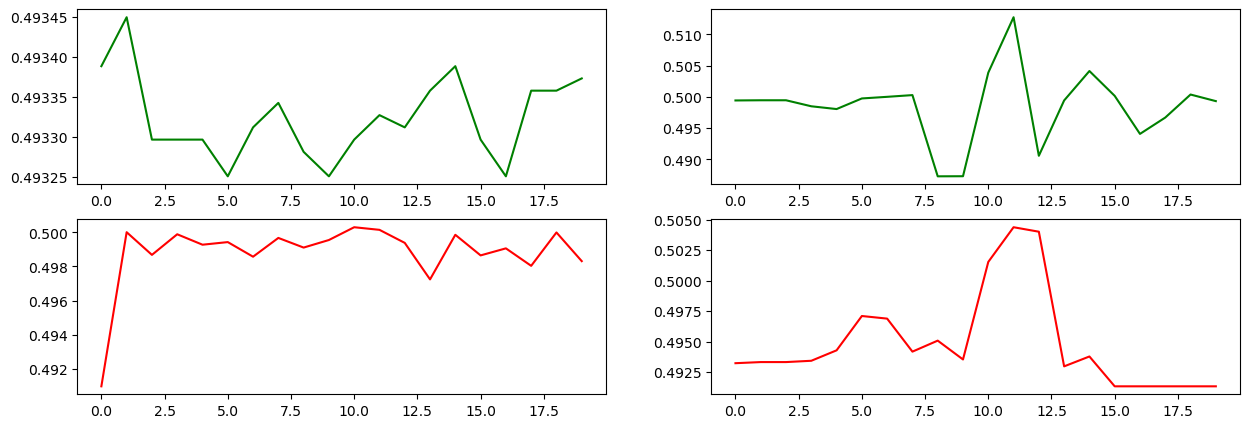

In [12]:
if mode == 'mean':
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0][0].plot(data_normal[np.random.randint(len(data_normal))].squeeze(), label='Normal signal', color='green')
    ax[0][1].plot(data_normal[np.random.randint(len(data_normal))].squeeze(), label='Normal signal', color='green')
    ax[1][0].plot(data_slow[np.random.randint(len(data_slow))].squeeze(), label='Anomalous signal', color='red')
    ax[1][1].plot(data_slow[np.random.randint(len(data_slow))].squeeze(), label='Anomalous signal', color='red')
elif (mode == '86' or mode == 'pca'):
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0][0].plot(data_normal[np.random.randint(len(data_normal)), :, 10], label='Normal signal', color='green')
    ax[0][1].plot(data_normal[np.random.randint(len(data_normal)), :, 10], label='Normal signal', color='green')
    ax[1][0].plot(data_slow[np.random.randint(len(data_slow)), :, 10], label='Anomalous signal', color='red')
    ax[1][1].plot(data_slow[np.random.randint(len(data_slow)), :, 10], label='Anomalous signal', color='red')

# Model definition
LSTM and CNN models

In [13]:
input_shape = (data_normal.shape[1], 1) if mode == 'mean' else (data_normal.shape[1], data_normal.shape[2])
if mode == 'mean':
    hid_dim1 = int(data_normal.shape[1]/2)
    hid_dim2 = int(data_normal.shape[1]/5)
else:
    hid_dim1 = int(data_normal.shape[2]/2)
    hid_dim2 = int(data_normal.shape[2]/5)
print(f'Input shape: {input_shape}')
print(f'Hidden dim 1: {hid_dim1}')
print(f'Hidden dim 2: {hid_dim2}')

if model == 'lstm':
    encoder = keras.models.Sequential(name='encoder')
    encoder.add(layers.LSTM(hid_dim1, activation='tanh', return_sequences=True, input_shape=input_shape))
    encoder.add(layers.LSTM(hid_dim2, activation='tanh', return_sequences=False))

    decoder = keras.models.Sequential(name='decoder')
    decoder.add(layers.RepeatVector(sequence_length))
    decoder.add(layers.LSTM(hid_dim2, activation='tanh', return_sequences=True))
    decoder.add(layers.LSTM(hid_dim1, activation='tanh', return_sequences=True))
    decoder.add(layers.TimeDistributed(layers.Dense(input_shape[1])))

    autoencoder = keras.models.Sequential()
    autoencoder.add(encoder)
    autoencoder.add(decoder)
elif model == 'conv':
    encoder = keras.models.Sequential()
    encoder.add(layers.Conv1D(filters=hid_dim1, kernel_size=7, padding="same", strides=2, activation="relu", input_shape=input_shape))
    #encoder.add(layers.Conv1D(filters=hid_dim2, kernel_size=7, padding="same", strides=2, activation="relu"))

    decoder = keras.models.Sequential()
    #decoder.add(layers.Conv1DTranspose(filters=hid_dim2, kernel_size=7, padding="same", strides=2, activation="relu"))
    decoder.add(layers.Conv1DTranspose(filters=hid_dim1, kernel_size=7, padding="same", strides=2, activation="relu"))
    decoder.add(layers.Conv1DTranspose(filters=data_normal.shape[2], kernel_size=7, padding="same", activation="sigmoid"))

    autoencoder = keras.models.Sequential()
    autoencoder.add(encoder)
    autoencoder.add(decoder)

Input shape: (20, 86)
Hidden dim 1: 43
Hidden dim 2: 17


2023-07-01 18:52:14.930636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
autoencoder.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 17)                26508     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| lstm (LSTM)               (None, 20, 43)            22360     |
|                                                               |
| lstm_1 (LSTM)             (None, 17)                4148      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder (Sequential)        (None, 20, 86)            16656     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| repeat_vector (RepeatVector  (None, 20, 17)         0         |
| )                                                             |
|                                                               |
| lstm_2 (LSTM)             (None, 20, 17)            2380      |
|                                                       

In [15]:
autoencoder.compile(optimizer='adam', loss='mae')

# Training

In [16]:
history = autoencoder.fit(data_normal, data_normal, validation_split=0.1, epochs=epochs, shuffle=True,
                          callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])

Epoch 1/5
6575/6575 [==============================] - 164s 24ms/step - loss: 0.0852 - val_loss: 0.0781
Epoch 2/5
6575/6575 [==============================] - 121s 18ms/step - loss: 0.0544 - val_loss: 0.0601
Epoch 3/5
6575/6575 [==============================] - 117s 18ms/step - loss: 0.0445 - val_loss: 0.0511
Epoch 4/5
6575/6575 [==============================] - 122s 19ms/step - loss: 0.0365 - val_loss: 0.0377
Epoch 5/5
6575/6575 [==============================] - 118s 18ms/step - loss: 0.0312 - val_loss: 0.0361


Text(0, 0.5, 'Loss')

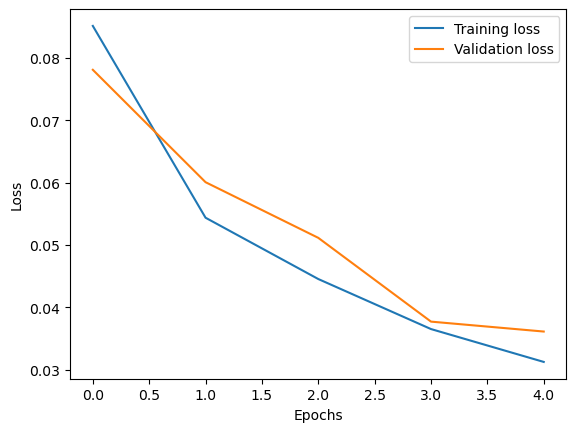

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

# Anomaly detection
Histogram plots with the reconstruction loss for both normal and anomalous sequences

In [18]:
n_test_samples = 300

10/10 [==============================] - 1s 5ms/step


Text(0, 0.5, 'No of examples')

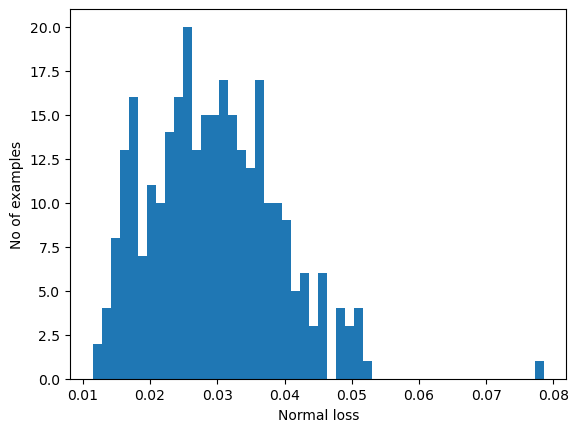

In [19]:
random_indexes = np.random.choice(len(data_normal), size=n_test_samples)
test_data = data_normal[random_indexes, :]
rec_normal = autoencoder.predict(test_data)

if mode == 'mean':
    normal_loss = np.mean(np.abs(rec_normal - test_data), axis=1)
else:
    normal_loss = np.mean(np.abs(rec_normal - test_data), axis=2)
    normal_loss = np.mean(normal_loss, axis=1)

plt.hist(normal_loss, bins=50)
plt.xlabel("Normal loss")
plt.ylabel("No of examples")

10/10 [==============================] - 0s 5ms/step


Text(0, 0.5, 'No of examples')

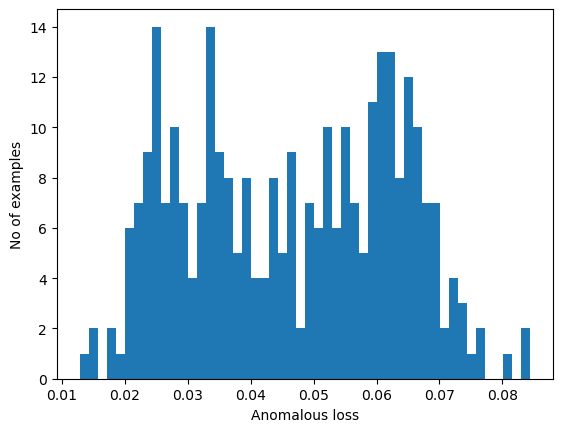

In [20]:
random_indexes = np.random.choice(len(data_slow), size=n_test_samples)
test_data = data_slow[random_indexes, :]
rec_slow = autoencoder.predict(test_data)

if mode == 'mean':
    anomalous_loss = np.mean(np.abs(rec_slow - test_data), axis=1)
else:
    anomalous_loss = np.mean(np.abs(rec_slow - test_data), axis=2)
    anomalous_loss = np.mean(anomalous_loss, axis=1)

plt.hist(anomalous_loss, bins=50)
plt.xlabel("Anomalous loss")
plt.ylabel("No of examples")

### Threshold fine-tuning

Text(0.5, 0, 'Sample index')

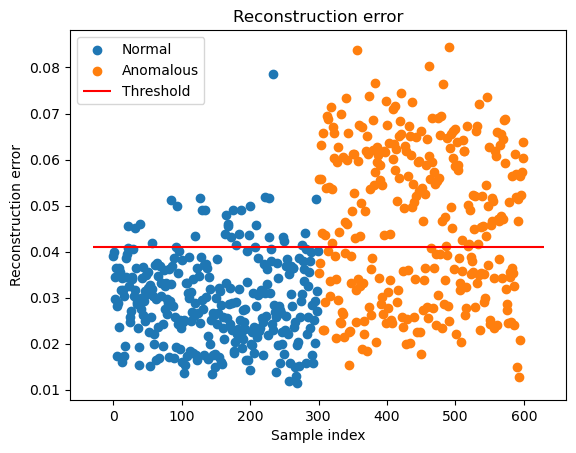

In [36]:
threshold = 0.041

fig, ax = plt.subplots()
ax.scatter(np.arange(n_test_samples), normal_loss, label='Normal')
ax.scatter(np.arange(n_test_samples, n_test_samples*2), anomalous_loss, label='Anomalous')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Sample index")

### Metrics

In [37]:
loss = np.concatenate((normal_loss, anomalous_loss))
target = np.concatenate((np.ones(n_test_samples), np.zeros(n_test_samples)))
pred = np.less(loss, threshold)

print(f'F1: {f1_score(target, pred, average="macro"):.3f}')
print(f'Accuracy: {accuracy_score(target, pred):.3f}')
print(f'Precision: {precision_score(target, pred, average="macro"):.3f}')
print(f'Recall: {recall_score(target, pred, average="macro"):.3f}')

F1: 0.734
Accuracy: 0.740
Precision: 0.764
Recall: 0.740


# Signal reconstruction

1/1 [==============================] - 0s 23ms/step


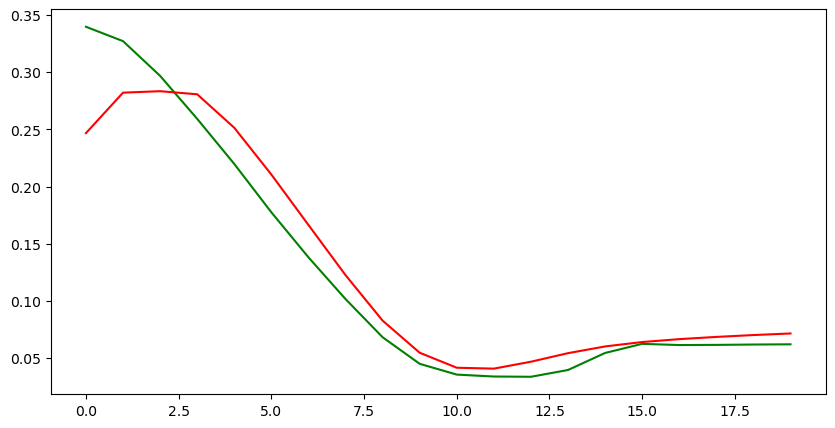

In [40]:
if mode == 'mean':
    sequence = np.random.randint(len(data_normal))
    signal = data_normal[sequence:sequence+1]
    reconstruction = autoencoder.predict(signal)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(signal.squeeze(), color='green')
    ax.plot(reconstruction.squeeze(), color='red')
elif mode == '86' or mode == 'pca':
    dimension = np.random.randint(86) if mode == '86' else np.random.randint(pca_dim)
    sequence = np.random.randint(len(data_normal))
    signal = data_normal[sequence:sequence+1, :, :]
    reconstruction = autoencoder.predict(signal)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(signal[0, :, dimension], color='green')
    ax.plot(reconstruction[0, :, dimension], color='red')